In [3]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# 1. Path to your folder containing 500 CSV files
data_dir = 'content/out'  # folder with dataset
# 2. Load all CSV files
all_files = glob.glob(os.path.join(data_dir, '*.csv'))

# 3. Combine all files into one big DataFrame and match labels correctly
data_list = []
labels = []

for file in all_files:
    df = pd.read_csv(file)
    data_list.append(df)

    filename = os.path.basename(file)  # e.g., ginger.001.csv
    label = filename.split('.')[0]     # e.g., 'ginger'

    #One label per row of data
    labels.extend([label] * len(df))

# Combine all data
full_data = pd.concat(data_list, ignore_index=True)

print(f"Loaded {len(full_data)} samples from {len(all_files)} files.")

# 4. Prepare features and labels
features = ['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co']
X = full_data[features].values
y = np.array(labels)

# 5. Encode labels (string --> number)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 8. Helper functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, targets):
    n_samples = predictions.shape[0]
    clipped_preds = np.clip(predictions, 1e-12, 1.0)  # <-- prevent log(0)
    logp = -np.log(clipped_preds[range(n_samples), targets])
    loss = np.sum(logp) / n_samples
    return loss

def accuracy(predictions, targets):
    preds = np.argmax(predictions, axis=1)
    return np.mean(preds == targets)

# 9. Initialize network
input_size = X_train.shape[1]  # Should be 8
hidden_size = 40
hidden_size_2 = 20
# values for the nmb of hidden layers, and their respective neuron value comes from the Edge Impulse websiteoutput_size = len(np.unique(y_train))  # Number of classes

#Train the network
epochs = 1500
learning_rate = 0.17
dropout_rate = 0.25

np.random.seed(42)
W1 = np.random.randn(input_size, hidden_size) * 0.1
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, hidden_size_2) * 0.1
b2 = np.zeros((1, hidden_size_2))
W3 = np.random.randn(hidden_size_2, output_size) * 0.1
b3 = np.zeros((1, output_size))

train_acc_history = []

for epoch in range(epochs):
    # Forward pass
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)

    # Apply dropout to first hidden layer
    dropout_mask1 = (np.random.rand(*a1.shape) > dropout_rate).astype(float)
    a1 *= dropout_mask1
    a1 /= (1.0 - dropout_rate)

    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)

    # Apply dropout to second hidden layer
    dropout_mask2 = (np.random.rand(*a2.shape) > dropout_rate).astype(float)
    a2 *= dropout_mask2
    a2 /= (1.0 - dropout_rate)

    z3 = np.dot(a2, W3) + b3
    a3 = softmax(z3)

    # Loss
    loss = cross_entropy_loss(a3, y_train)

    n_samples = X_train.shape[0]
    delta3 = a3.copy()
    delta3[range(n_samples), y_train] -= 1
    delta3 /= n_samples

    dW3 = np.dot(a2.T, delta3)
    db3 = np.sum(delta3, axis=0, keepdims=True)

    delta2 = np.dot(delta3, W3.T) * relu_derivative(z2)
    dW2 = np.dot(a1.T, delta2)
    db2 = np.sum(delta2, axis=0, keepdims=True)

    delta1 = np.dot(delta2, W2.T) * relu_derivative(z1)
    dW1 = np.dot(X_train.T, delta1)
    db1 = np.sum(delta1, axis=0, keepdims=True)

    # Update weights and biases
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3

    # Record training accuracy (using a3 now)
    train_acc = accuracy(a3, y_train)
    train_acc_history.append(train_acc)

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Train Accuracy: {train_acc*100:.2f}%')

# 11. Test the network
z1 = np.dot(X_test, W1) + b1
a1 = relu(z1)
z2 = np.dot(a1, W2) + b2
a2 = relu(z2)
z3 = np.dot(a2, W3) + b3
a3 = softmax(z3)
test_acc = accuracy(a3, y_test)
print(f'Test Accuracy: {test_acc*100:.2f}%')

Loaded 9968 samples from 1246 files.
Epoch 10/1500, Loss: 1.7583, Train Accuracy: 28.08%
Epoch 20/1500, Loss: 1.7282, Train Accuracy: 26.81%
Epoch 30/1500, Loss: 1.6938, Train Accuracy: 32.43%
Epoch 40/1500, Loss: 1.6404, Train Accuracy: 43.98%
Epoch 50/1500, Loss: 1.5572, Train Accuracy: 51.79%
Epoch 60/1500, Loss: 1.4516, Train Accuracy: 54.39%
Epoch 70/1500, Loss: 1.3379, Train Accuracy: 57.34%
Epoch 80/1500, Loss: 1.2297, Train Accuracy: 60.16%
Epoch 90/1500, Loss: 1.1262, Train Accuracy: 62.19%
Epoch 100/1500, Loss: 1.0341, Train Accuracy: 63.84%
Epoch 110/1500, Loss: 0.9499, Train Accuracy: 66.04%
Epoch 120/1500, Loss: 0.8917, Train Accuracy: 68.30%
Epoch 130/1500, Loss: 0.8371, Train Accuracy: 69.54%
Epoch 140/1500, Loss: 0.7911, Train Accuracy: 70.18%
Epoch 150/1500, Loss: 0.7512, Train Accuracy: 71.92%
Epoch 160/1500, Loss: 0.7173, Train Accuracy: 72.52%
Epoch 170/1500, Loss: 0.6736, Train Accuracy: 74.23%
Epoch 180/1500, Loss: 0.6608, Train Accuracy: 74.32%
Epoch 190/1500, Lo

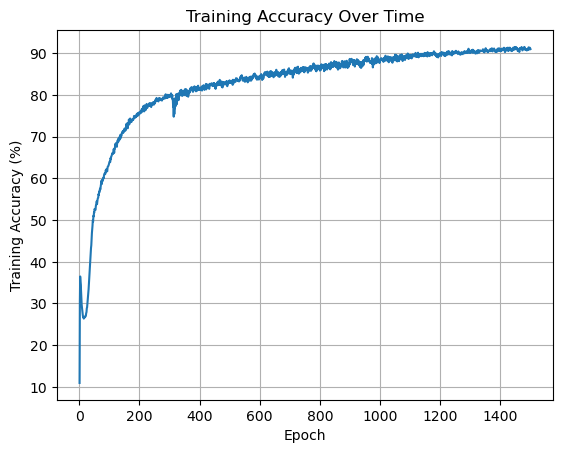

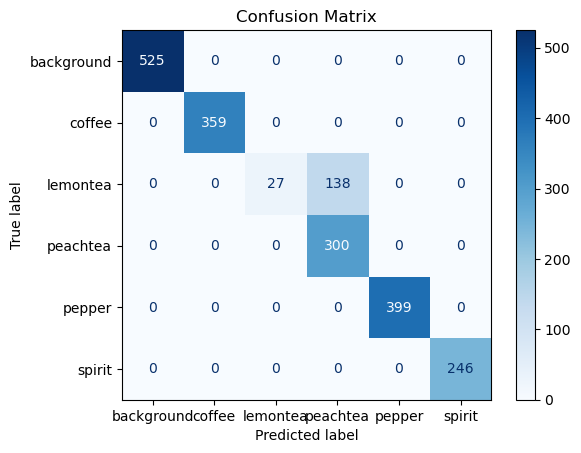

In [5]:
# 12. (Optional) Plot training accuracy over epochs
plt.plot(range(1, epochs+1), np.array(train_acc_history)*100)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.grid(True)
plt.show()

y_pred = np.argmax(a3, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()